In [2]:
import os
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss, coint, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import matplotlib

In [16]:
FIRST_SLICE_DATE: datetime = datetime.strptime('27/10/2018', '%d/%m/%Y')
SECOND_SLICE_DATE: datetime = datetime.strptime('1/5/2020', '%d/%m/%Y')

In [155]:
def filter_series(df: pd.DataFrame, date_key: str, slice1: datetime, slice2: datetime) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, date_key] = pd.to_datetime(dff.loc[:, date_key], unit='s')

    dff.loc[:, :] = dff[dff[date_key] > slice1]
    dff.loc[:, :] = dff[dff[date_key] < slice2]
    
    dff = dff.set_index(date_key)

    return dff.dropna()

In [18]:
def print_adf(df: pd.DataFrame, values_key: str) -> None:
    series = df.loc[:, values_key].values

    adf_test = adfuller(series, autolag='AIC')
    p_value = adf_test[1]

    dfResults = pd.Series(adf_test[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    #Add Critical Values
    for key,value in adf_test[4].items():
        dfResults[f'Critical Value ({key})'] = value

    print('Augmented Dickey-Fuller Test Results:')
    print(dfResults)

In [19]:
def print_kpss(df: pd.DataFrame, values_key: str) -> None:
    series = df.loc[:, values_key].values

    statistic, p_value, n_lags, critical_values = kpss(series, nlags="auto", regression='c')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')

    for key, value in critical_values.items():
        print(f'   {key} : {value}')

# GAS series

Loading and cleaning gas data.

In [156]:
gas: pd.DataFrame = pd.read_csv(os.path.join('data', 'avg_gas_price.csv'), header=0)
gas.rename(columns={'UnixTimeStamp': 'date', 'Value (Wei)': 'values'}, inplace = True)
gas = gas[['date', 'values']].dropna()

## Original series

Let's see how the series looks like.

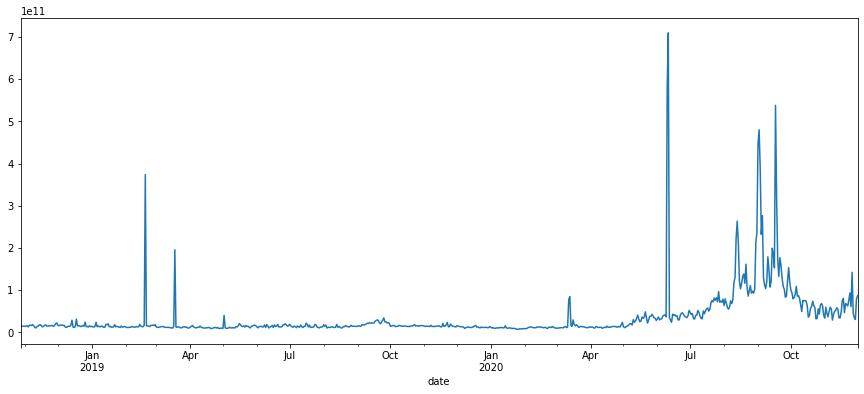

In [157]:
gas_plot = filter_series(df=gas, date_key='date', slice1=FIRST_SLICE_DATE, slice2=datetime.today())
gas_plot['values'].plot(figsize = (15, 6))
plt.show()

## Splitting the series

We can see there is two-stage in the series. The first stage ends around May first of 2020, from then the series changed. So let's split the series into two slices. 

In [158]:
gas_slice1 = filter_series(df=gas, date_key='date', slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
gas_slice2 = filter_series(df=gas, date_key='date', slice1=SECOND_SLICE_DATE, slice2=datetime.now())

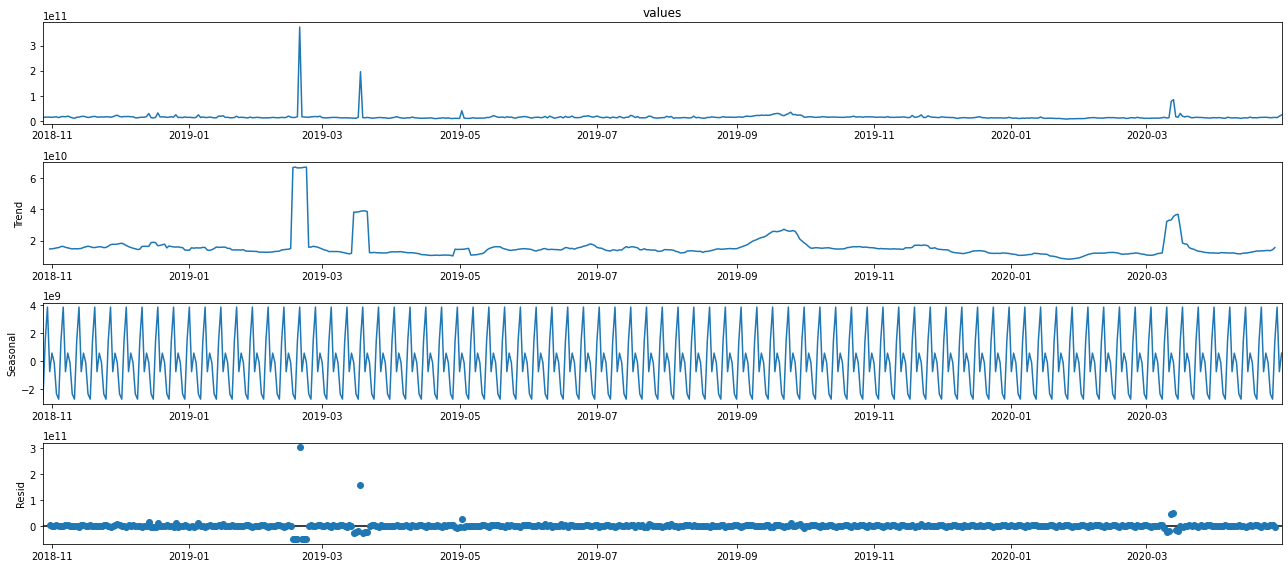

In [160]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=gas_slice1['values'], model='additive')
fig = decomposition.plot()
plt.show()

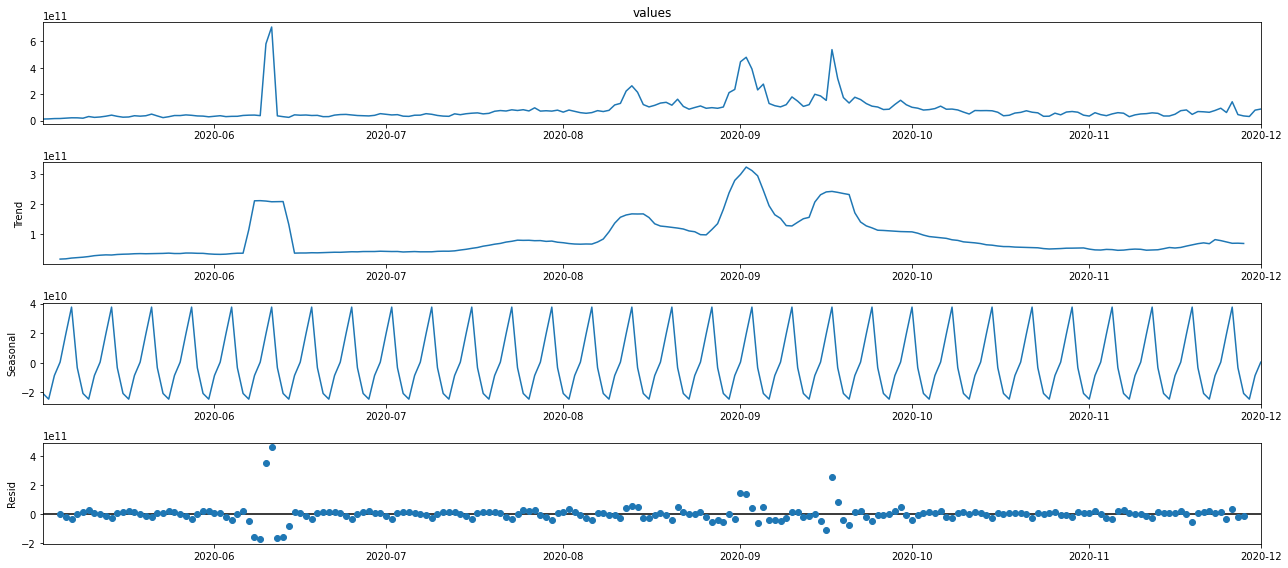

In [162]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=gas_slice2['values'], model='additive')
fig = decomposition.plot()
plt.show()

Let's apply a log transformation to reduce higher values, and also remove the weekly seasonality.

In [163]:
gas_slice1['values'] = np.log(gas_slice1['values'])

N = 7
gas_slice1['values'] = gas_slice1['values'] - gas_slice1['values'].shift(N)
gas_slice1.dropna(inplace=True)

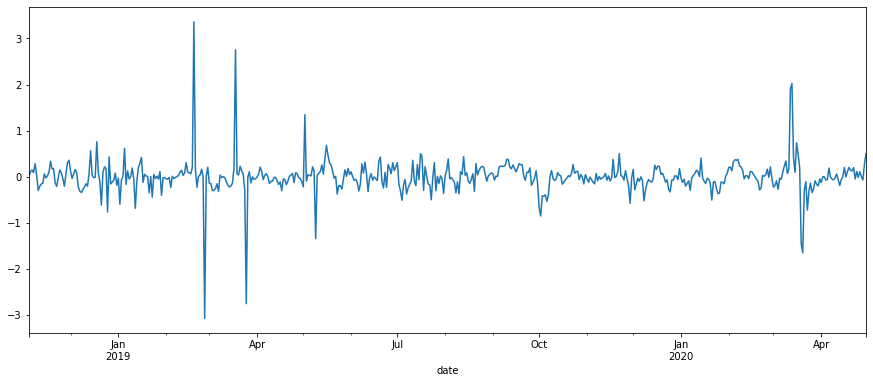

In [164]:
gas_slice1['values'].plot(figsize = (15, 6))
plt.show()

In [165]:
gas_slice2['values'] = np.log(gas_slice2['values'])

gas_slice2['values'] = gas_slice2['values'] - gas_slice2['values'].shift(N)
gas_slice2.dropna(inplace=True)

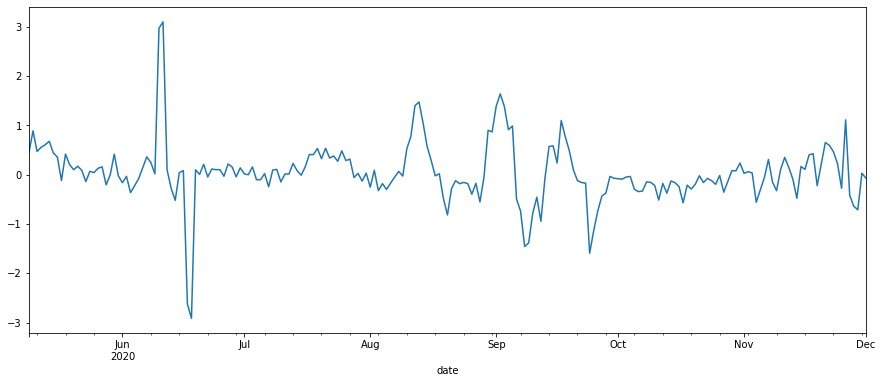

In [166]:
gas_slice2['values'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [167]:
print_adf(df=gas_slice1, values_key='values')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.496535e+00
P-Value                 4.364663e-11
# Lags Used             1.900000e+01
# Observations Used     5.240000e+02
Critical Value (1%)    -3.442891e+00
Critical Value (5%)    -2.867072e+00
Critical Value (10%)   -2.569716e+00
dtype: float64


In [168]:
print_adf(df=gas_slice2, values_key='values')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.701068
P-Value                   0.004098
# Lags Used              14.000000
# Observations Used     192.000000
Critical Value (1%)      -3.464875
Critical Value (5%)      -2.876714
Critical Value (10%)     -2.574859
dtype: float64


In both cases, we can reject the null hypothesis with all the confidence intervals. So, both series haven't a unit root. Hence, they are stationary series.

To confirm that, we are going to perform the kpss test for cross-validation.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [169]:
print_kpss(df=gas_slice1, values_key='values')

KPSS Statistic: 0.018995740148200893
p-value: 0.1
num lags: 9
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/granger-causality-gas-test/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [170]:
print_kpss(df=gas_slice2, values_key='values')

KPSS Statistic: 0.2106854221492252
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/granger-causality-gas-test/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In both cases, p-values are greater than 0.05, and "KPSS Statistic" values are less than the critical values. So, we fail to reject H0, and because of that, we confirm that both series are stationary.

# Aragon activity series

Let's check what about the activity series.

In [171]:
aragon: pd.DataFrame = pd.read_csv(os.path.join('data', 'aragon_activity.csv'), header=0)

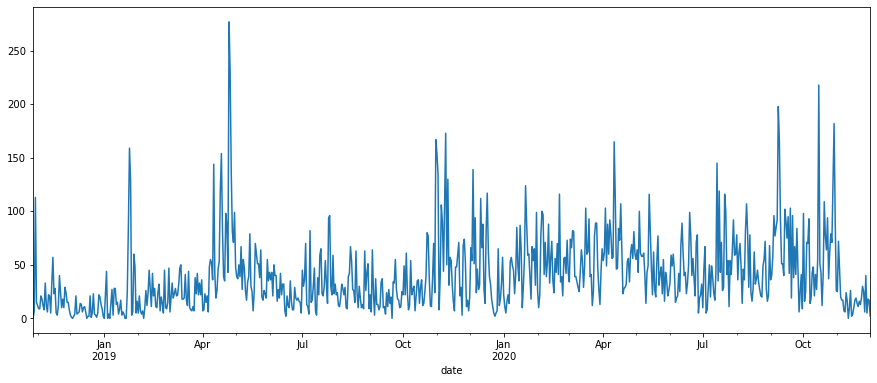

In [172]:
aragon_plot = filter_series(df=aragon, date_key='date', slice1=FIRST_SLICE_DATE, slice2=datetime.today())
aragon_plot['actions'].plot(figsize = (15, 6))
plt.show()

## Spliting the series

As we previously do with the gas series, let's split the series.

In [175]:
aragon_slice1 = filter_series(df=aragon, date_key='date', slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
aragon_slice2 = filter_series(df=aragon, date_key='date', slice1=SECOND_SLICE_DATE, slice2=datetime.now())

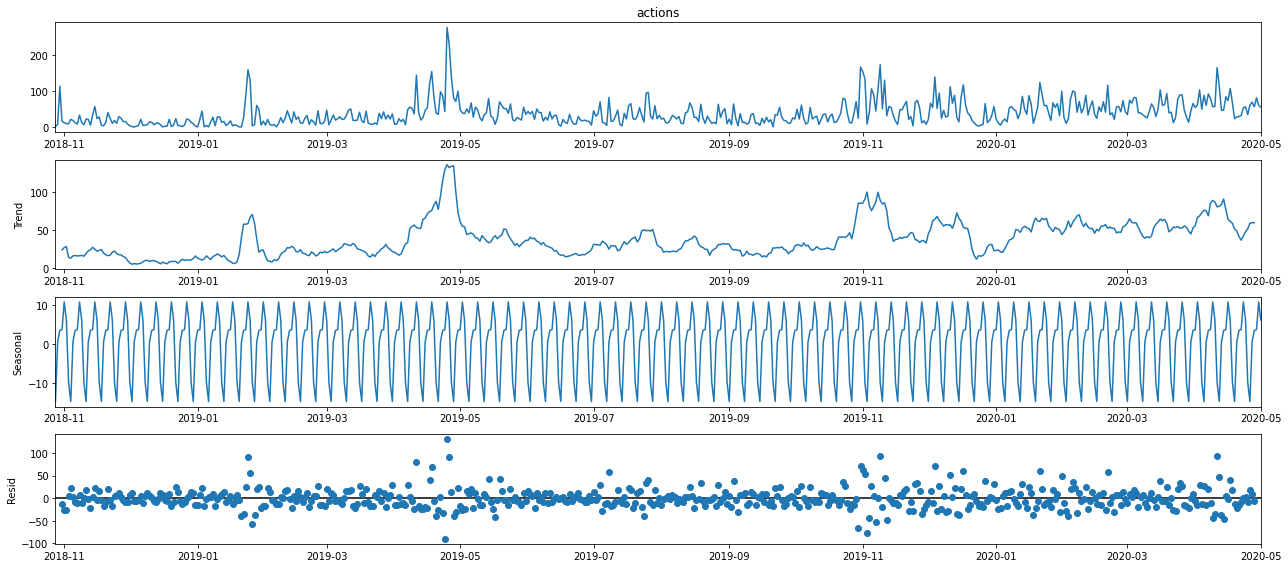

In [129]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=aragon_slice1['actions'], model='additive')
fig = decomposition.plot()
plt.show()

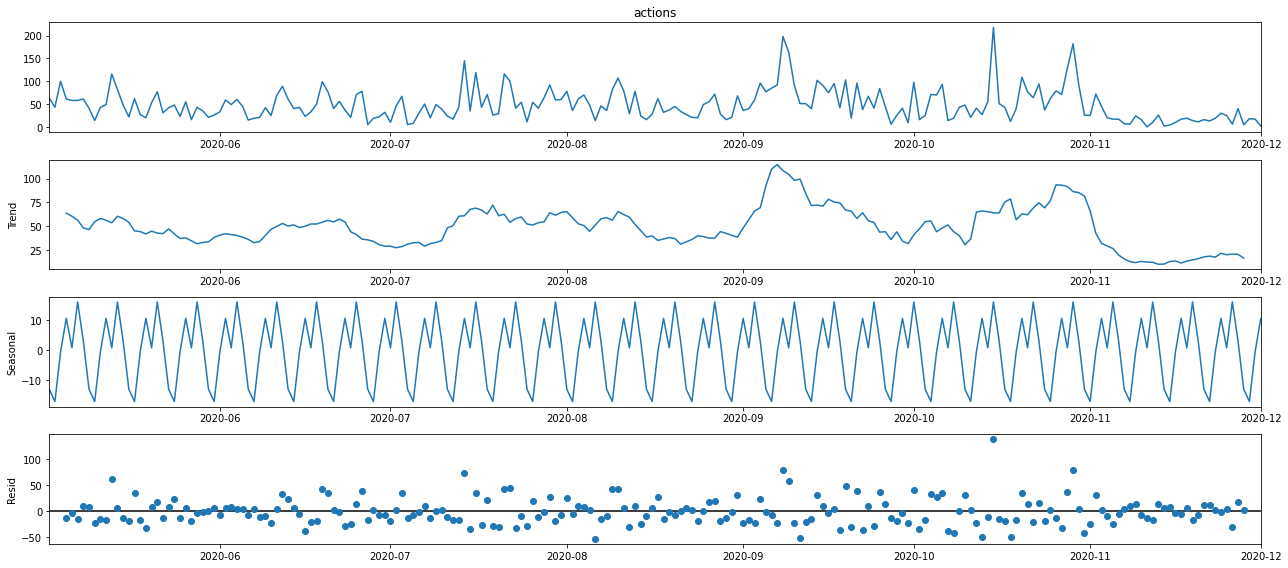

In [130]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=aragon_slice2['actions'], model='additive')
fig = decomposition.plot()
plt.show()

In [176]:
aragon_slice1['actions'] = np.log(aragon_slice1['actions'])
aragon_slice1['actions'].replace(np.NINF, np.log(0.1), inplace=True)

aragon_slice1['actions'] = aragon_slice1['actions'] - aragon_slice1['actions'].shift(N)
aragon_slice1.dropna(inplace=True)

             actions
date                
2018-11-04  3.044522
2018-11-05  0.944462
2018-11-06 -2.242481
2018-11-07 -0.628609
2018-11-08  1.011601
...              ...
2020-04-26  0.975380
2020-04-27  0.901902
2020-04-28  0.658056
2020-04-29  0.928713
2020-04-30  0.124053

[544 rows x 1 columns]


/home/youss/Documentos/granger-causality-gas-test/venv/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


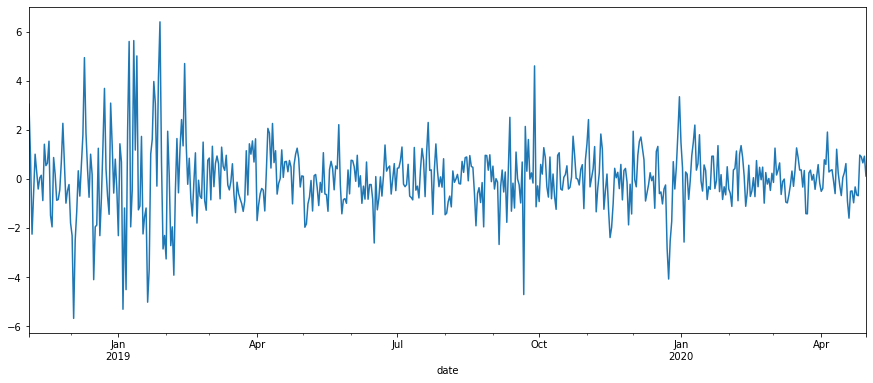

In [177]:
aragon_slice1['actions'].plot(figsize = (15, 6))
plt.show()

In [178]:
aragon_slice2['actions'] = np.log(aragon_slice2['actions'])
aragon_slice2['actions'].replace(np.NINF, np.log(0.1), inplace=True)

aragon_slice2['actions'] = aragon_slice2['actions'] - aragon_slice2['actions'].shift(N)
aragon_slice2.dropna(inplace=True)

/home/youss/Documentos/granger-causality-gas-test/venv/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


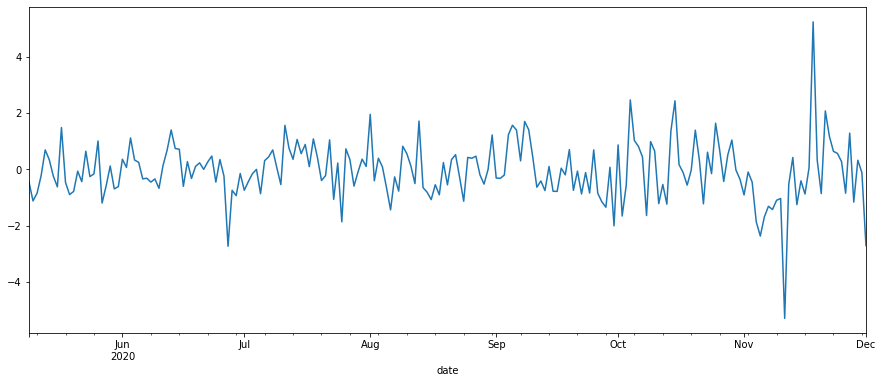

In [179]:
aragon_slice2['actions'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [180]:
print_adf(df=aragon_slice1, values_key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.305475e+00
P-Value                 1.304983e-10
# Lags Used             1.400000e+01
# Observations Used     5.290000e+02
Critical Value (1%)    -3.442772e+00
Critical Value (5%)    -2.867019e+00
Critical Value (10%)   -2.569688e+00
dtype: float64


In [181]:
print_adf(df=aragon_slice2, values_key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.902375
P-Value                   0.000035
# Lags Used              14.000000
# Observations Used     192.000000
Critical Value (1%)      -3.464875
Critical Value (5%)      -2.876714
Critical Value (10%)     -2.574859
dtype: float64


In the first series, either p-value or statistic value are lower than all the confidence and critical values. In the second case, its p-value is slower than the 0.05 confidence interval. Those results suggest that we can reject H0 in favor of H1, in other words, both series are stationary.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [182]:
print_kpss(df=aragon_slice1, values_key='actions')

KPSS Statistic: 0.011967131447353358
p-value: 0.1
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/granger-causality-gas-test/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [183]:
print_kpss(df=aragon_slice2, values_key='actions')

KPSS Statistic: 0.06336136267285225
p-value: 0.1
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/granger-causality-gas-test/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Both series have values that suggest that we fail to reject H0. So, it is definitely a stationary series.

# Granger Causality Tests

Where:

    * H0: The second column, x2, does NOT Granger cause the time series in the first column, x1
    * H1: x2 Granger cause x1

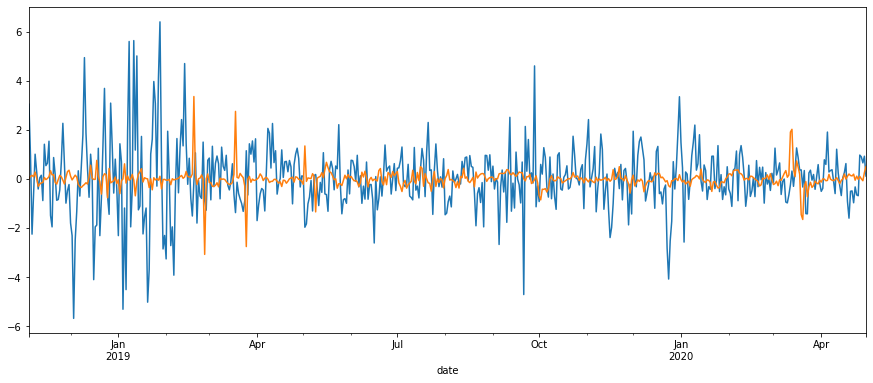

In [186]:
aragon_slice1['actions'].plot(figsize = (15, 6))
gas_slice1['values'].plot()
plt.show()

In [184]:
slice1: pd.DataFrame = pd.DataFrame(
    {'aragon_actions': aragon_slice1['actions'].tolist(),
     'gasPrice': gas_slice1['values'].tolist(),
    })
    
gc_res1 = grangercausalitytests(slice1, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4645  , p=0.4958  , df_denom=540, df_num=1
ssr based chi2 test:   chi2=0.4671  , p=0.4943  , df=1
likelihood ratio test: chi2=0.4669  , p=0.4944  , df=1
parameter F test:         F=0.4645  , p=0.4958  , df_denom=540, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2514  , p=0.0395  , df_denom=537, df_num=2
ssr based chi2 test:   chi2=6.5633  , p=0.0376  , df=2
likelihood ratio test: chi2=6.5239  , p=0.0383  , df=2
parameter F test:         F=3.2514  , p=0.0395  , df_denom=537, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2911  , p=0.0773  , df_denom=534, df_num=3
ssr based chi2 test:   chi2=6.9635  , p=0.0731  , df=3
likelihood ratio test: chi2=6.9191  , p=0.0745  , df=3
parameter F test:         F=2.2911  , p=0.0773  , df_denom=534, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7795  , p=0.1315  

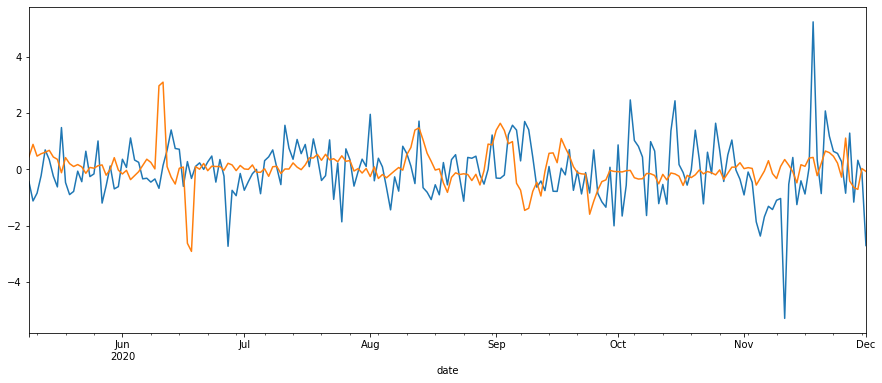

In [187]:
aragon_slice2['actions'].plot(figsize = (15, 6))
gas_slice2['values'].plot()
plt.show()

In [185]:
slice2: pd.DataFrame = pd.DataFrame(
    {'aragon_actions': aragon_slice2['actions'].tolist(),
     'gasPrice': gas_slice2['values'].tolist(),
    })
    
gc_res2 = grangercausalitytests(slice2, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4077  , p=0.2368  , df_denom=203, df_num=1
ssr based chi2 test:   chi2=1.4285  , p=0.2320  , df=1
likelihood ratio test: chi2=1.4235  , p=0.2328  , df=1
parameter F test:         F=1.4077  , p=0.2368  , df_denom=203, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9509  , p=0.3881  , df_denom=200, df_num=2
ssr based chi2 test:   chi2=1.9493  , p=0.3773  , df=2
likelihood ratio test: chi2=1.9401  , p=0.3791  , df=2
parameter F test:         F=0.9509  , p=0.3881  , df_denom=200, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6107  , p=0.1882  , df_denom=197, df_num=3
ssr based chi2 test:   chi2=5.0037  , p=0.1715  , df=3
likelihood ratio test: chi2=4.9433  , p=0.1760  , df=3
parameter F test:         F=1.6107  , p=0.1882  , df_denom=197, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3987  , p=0.2359  